### Loading datasets and importing libraries

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving semeval_test.txt to semeval_test.txt
Saving semeval_train.txt to semeval_train.txt
User uploaded file "semeval_test.txt" with length 418243 bytes
User uploaded file "semeval_train.txt" with length 1235657 bytes


In [ ]:
import re
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load("en_core_web_sm")
from IPython.core.display import display, HTML
from spacy import displacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem.porter import *
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## **Task 1**


### Reading text files to DataFrame

In [ ]:
def CorpusReader(filename):
  f = open(filename,"r")
  data = f.readlines()

  relations = []
  sentences = []
  e1 = []
  e2 = []

  for i in range(len(data)):
    if i%4 == 0:
      sentences.append(data[i].split('\t')[1].strip('\n\t\s '))
      e1.append(str(re.findall(r'<e.>.*?</e.>', data[i])[0][4:-5].strip()))
      e2.append(str(re.findall(r'<e.>.*?</e.>', data[i])[1][4:-5].strip()))
    elif i%4 == 1:
      relations.append(data[i][:-1])
  
  df = pd.DataFrame()
  df['Sentence'] = sentences
  df['Relation_Direction'] = relations
  df['Relation'] = df['Relation_Direction'].apply(lambda x: x if x == 'Other' else x[:-7])
  df['Direction'] = df['Relation_Direction'].apply(lambda x: 'ND' if x =='Other' else x[-7:])
  df['Entity1'] = e1
  df['Entity2'] = e2
  df['Sentence'].replace(regex=['<e1>', '</e1>', '<e2>', '</e2>'], value=' ', inplace=True)
  df['Sentence'] = df['Sentence'].str.strip('" ')
  df['Sentence'] = df['Sentence'].apply(lambda x: re.sub(' +', ' ', x))
  return df

In [ ]:
trainDF = CorpusReader("semeval_train.txt")
testDF = CorpusReader("semeval_test.txt")

### Visualization of labels

Total number of uniqie relations in train data: 19


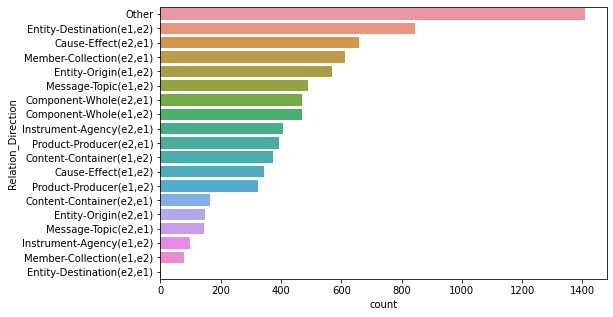

In [ ]:
print("Total number of uniqie relations in train data:", len(trainDF['Relation_Direction'].unique()))
plt.figure(figsize=(8,5))
plot = sns.countplot(data=trainDF, y='Relation_Direction', order=trainDF.Relation_Direction.value_counts().index)

Total number of uniqie relations in train data without direction: 10


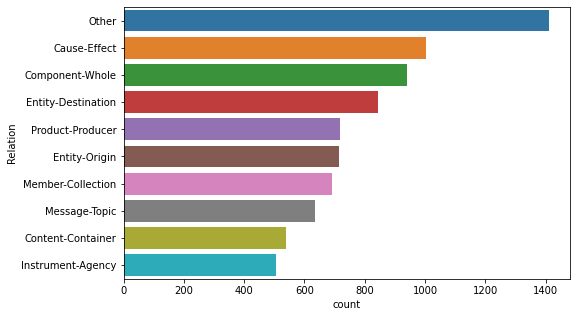

In [ ]:
print("Total number of uniqie relations in train data without direction:", len(trainDF['Relation'].unique()))
plt.figure(figsize=(8,5))
sns.countplot(data=trainDF, y='Relation', order=trainDF.Relation.value_counts().index)

In [ ]:
trainDF.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2
0,The system as described above has its greatest...,"Component-Whole(e2,e1)",Component-Whole,"(e2,e1)",configuration,elements
1,The child was carefully wrapped and bound into...,Other,Other,ND,child,cradle
2,The author of a keygen uses a disassembler to ...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",author,disassembler
3,A misty ridge uprises from the surge .,Other,Other,ND,ridge,surge
4,The student association is the voice of the un...,"Member-Collection(e1,e2)",Member-Collection,"(e1,e2)",student,association


## **Task 2**

In [ ]:
# Tokens
def get_tokens(sentence):
  return [word.text for word in nlp(sentence)]

In [ ]:
# Lemmas
def get_lemmas(sentence):
  return [word.lemma_ for word in nlp(sentence)]

In [ ]:
# Penn Treebank POS Tags
def get_POS_tags(sentence):
  return [word.tag_ for word in nlp(sentence)]

### Dependency Parse Tree Features

In [ ]:
# Dependency Parse Tags for each word and its head
def get_DEP_tags(sentence):
  return [word.dep_ for word in nlp(sentence)]

# Dependency Parse POS tag for head of each word
def get_DEP_Parent_POS(sentence):
  return [word.head.pos_ for word in nlp(sentence)]

In [ ]:
def find_sub_list(l, sublist):
  sl_length = len(sublist)
  if sl_length == 0:
    return [-1, -1]
  for ind in (i for i, e in enumerate(l) if e == sublist[0]):
    if l[ind: ind+sl_length] == sublist:
      return [ind, ind + sl_length - 1]

### Shortest Dependency Path

In [ ]:
# Shortest Dependency Path
def dep(sentence, entity1, entity2, direction):
  shortest_dep_path = []
  length = 0
  tokens = get_tokens(sentence)

  entity1_tokens = get_tokens(entity1)
  entity2_tokens = get_tokens(entity2)
  if len(entity1_tokens) == 0 or len(entity2_tokens) == 0:
    return pd.Series((shortest_dep_path, length))

  for chunk in nlp(entity1).noun_chunks:
    entity1 = chunk.root.head.text

  for chunk in nlp(entity2).noun_chunks:
    entity2 = chunk.root.head.text

  edges = []
  data = []
  graph = nx.Graph(edges)
  for token in nlp(sentence):
    data.append([token.head.text, token.text, token.dep_])
    for child in token.children:
      graph.add_edge(token.text, child.text)

  # To plot the graph
  # nx.draw(graph, with_labels=True)
  
  if graph.has_node(entity1) and graph.has_node(entity2) and nx.has_path(graph, entity1, entity2):
    if direction == '(e2,e1)':
      path = nx.shortest_path(graph, source=entity2, target=entity1)
    else:
      path = nx.shortest_path(graph, source=entity1, target=entity2)
    length = nx.shortest_path_length(graph, entity1, entity2)
  else:
    path = []

  for i in range(len(path)-1):
    for j in data:
      if j[0].lower() == path[i].lower() and j[1].lower() == path[i+1].lower():
        shortest_dep_path.append(j[2])
      elif j[0].lower() == path[i+1].lower() and j[1].lower() == path[i].lower():
        shortest_dep_path.append(j[2])
  return pd.Series((shortest_dep_path, length))

0    [compound, prep, pobj]
1                         3
dtype: object
ridge
surge
ND


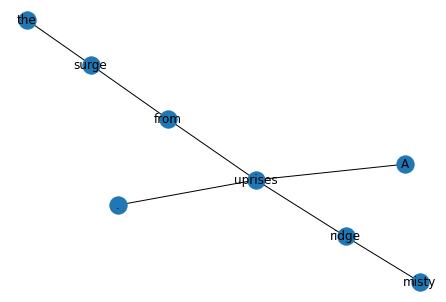

In [ ]:
# Shortest Depencey Path Display
i = 3
print(dep(trainDF.iloc[i,0], trainDF.iloc[i,4], trainDF.iloc[i,5], trainDF.iloc[i,3]))
print(trainDF.iloc[i,4])
print(trainDF.iloc[i,5])
print(trainDF.iloc[i,3])

options = {"collapse_phrases" : False}
html = displacy.render(nlp(trainDF.iloc[i,0]), style="dep")
display(HTML(html))

### WordNet features

In [ ]:
def get_entity_POS(sentence, entity):
  entity_tokens = get_tokens(entity)
  sentence_tokens = get_tokens(sentence)

  if len(entity_tokens) == 0:
    return 'X'

  e1_start, e1_end = find_sub_list(sentence_tokens, entity_tokens)

  pos = get_POS_tags(sentence)
  if e1_start == e1_end:
    return pos[e1_start]
  else:
    for chunk in nlp(entity).noun_chunks:
      return pos[sentence_tokens.index(chunk.root.head.text)]
  return 'X'

In [ ]:
def get_wordnet_pos(entity_pos):
  pos = None
  if entity_pos.startswith('J'):
    pos = wordnet.ADJ
  elif entity_pos.startswith('N'):
    pos = wordnet.NOUN
  elif entity_pos.startswith('R'):
    pos = wordnet.ADV
  elif entity_pos.startswith('V'):
    pos = wordnet.VERB
  return pos

In [ ]:
# hypernymns, hyponyms, meronyms, holonyms and synset similarities
def get_synsets(entity, entity_pos):
  entity = str(entity)
  
  pos = get_wordnet_pos(entity_pos)
  hype = ['O']
  hypo = ['O']
  mero = ['O']
  holo = ['O']

  syn = wordnet.synsets(entity, pos=pos)
  if len(syn) > 0:
    hype = [x.name().split('.')[0] for x in syn[0].hypernyms()]
    hypo = [x.name().split('.')[0] for x in syn[0].hyponyms()]
    mero = [x.name().split('.')[0] for x in syn[0].part_meronyms()]
    holo = [x.name().split('.')[0] for x in syn[0].member_holonyms()]

  hype = ['O'] if len(hype) == 0 else hype
  hypo = ['O'] if len(hypo) == 0 else hypo
  mero = ['O'] if len(mero) == 0 else mero
  holo = ['O'] if len(holo) == 0 else holo

  return pd.Series((hype, hypo, mero, holo))

In [ ]:
# hypernymns, hyponyms, meronyms, holonyms and synset similarities
def is_synset(entity1, entity2, entity_pos1, entity_pos2):
  entity1 = str(entity1)
  entity2 = str(entity2)
  
  pos1 = get_wordnet_pos(entity_pos1)
  pos2 = get_wordnet_pos(entity_pos2)
  hype1 = []
  hypo1 = []
  mero1 = []
  holo1 = []
  hype2 = []
  hypo2 = []
  mero2 = []
  holo2 = ['O']

  syn1 = wordnet.synsets(entity1, pos=pos1)
  syn2 = wordnet.synsets(entity2, pos=pos2)
  if len(syn1) > 0:
    hype1 = [x.name().split('.')[0].lower() for x in syn1[0].hypernyms()] + [x.name().split('.')[0].lower() for x in syn1[0].instance_hypernyms()]
    hypo1 = [x.name().split('.')[0].lower() for x in syn1[0].hyponyms()] + [x.name().split('.')[0].lower() for x in syn1[0].instance_hyponyms()]
    mero1 = [x.name().split('.')[0].lower() for x in syn1[0].part_meronyms()] + [x.name().split('.')[0].lower() for x in syn1[0].member_meronyms()] + [x.name().split('.')[0].lower() for x in syn1[0].substance_meronyms()] 
    holo1 = [x.name().split('.')[0].lower() for x in syn1[0].member_holonyms()] + [x.name().split('.')[0].lower() for x in syn1[0].part_holonyms()] + [x.name().split('.')[0].lower() for x in syn1[0].substance_holonyms()]
  if len(syn2) > 0:
    hype2 = [x.name().split('.')[0].lower() for x in syn2[0].hypernyms()] + [x.name().split('.')[0].lower() for x in syn2[0].instance_hypernyms()]
    hypo2 = [x.name().split('.')[0].lower() for x in syn2[0].hyponyms()] + [x.name().split('.')[0].lower() for x in syn2[0].instance_hyponyms()]
    mero2 = [x.name().split('.')[0].lower() for x in syn2[0].part_meronyms()] + [x.name().split('.')[0].lower() for x in syn2[0].member_meronyms()] + [x.name().split('.')[0].lower() for x in syn2[0].substance_meronyms()] 
    holo2 = [x.name().split('.')[0].lower() for x in syn2[0].member_holonyms()] + [x.name().split('.')[0].lower() for x in syn2[0].part_holonyms()] + [x.name().split('.')[0].lower() for x in syn2[0].substance_holonyms()]

  hypeE1 = 1 if entity1 in hype2 else 0
  hypoE1 = 1 if entity1 in hypo2 else 0
  meroE1 = 1 if entity1 in mero2 else 0
  holoE1 = 1 if entity1 in holo2 else 0

  hypeE2 = 1 if entity1 in hype1 else 0
  hypoE2 = 1 if entity1 in hypo1 else 0
  meroE2 = 1 if entity1 in mero1 else 0
  holoE2 = 1 if entity1 in holo1 else 0  

  return pd.Series((hypeE1, hypoE1, meroE1, holoE1, hypeE2, hypoE2, meroE2, holoE2))

In [ ]:
# Path similarity
def get_similarities(entity1, entity2, entity1_pos, entity2_pos):
  pos1 = get_wordnet_pos(entity1)
  pos2 = get_wordnet_pos(entity2)

  synsets1 = wordnet.synsets(entity1, pos=pos1)
  synsets2 = wordnet.synsets(entity2, pos=pos2)

  if len(synsets1) > 0 and len(synsets2) > 0:
    similarity = synsets1[0].path_similarity(synsets2[0])
  else:
    similarity = 0.0
  return similarity if similarity else 0.0

### Named Entities

In [ ]:
# NER using spaCy
def NER(sentence, entity1, entity2):
  doc = nlp(sentence)
  e1 = 'NONE'
  e2 = 'NONE'

  for chunk in nlp(entity1).noun_chunks:
    entity1 = chunk.root.head.text

  for chunk in nlp(entity2).noun_chunks:
    entity2 = chunk.root.head.text
    
  for ent in doc.ents:
    if entity1 in ent.text:
      e1 = ent.label_
    elif entity2 in ent.text:
      e2 = ent.label_
  return pd.Series((e1, e2))

In [ ]:
def features(DataFrame):
  DataFrame['Entity1_POS'] = DataFrame.apply(lambda x: get_entity_POS(x.Sentence, x.Entity1), axis=1)
  DataFrame['Entity2_POS'] = DataFrame.apply(lambda x: get_entity_POS(x.Sentence, x.Entity2), axis=1)
  DataFrame['Tokens'] = DataFrame.apply(lambda x: get_tokens(x.Sentence), axis=1)
  DataFrame['Lemmas'] = DataFrame.apply(lambda x: get_lemmas(x.Sentence), axis=1)
  DataFrame['POS Tags'] = DataFrame.apply(lambda x: get_POS_tags(x.Sentence), axis=1)
  DataFrame['DEP Tags'] = DataFrame.apply(lambda x: get_DEP_tags(x.Sentence), axis=1)
  DataFrame['DEP Parent POS'] = DataFrame.apply(lambda x: get_DEP_Parent_POS(x.Sentence), axis=1)
  DataFrame[['ShortestPath', 'ShortestPathLength']] = DataFrame.apply(lambda x: dep(x.Sentence, x.Entity1, x.Entity2, x.Direction), axis=1)
  DataFrame[['NE1', 'NE2']] = DataFrame.apply(lambda x: NER(x.Sentence, x.Entity1, x.Entity2), axis=1)
  DataFrame[['is_E1_hype', 'is_E1_hypo', 'is_E1_mero', 'is_E1_holo', 'is_E2_hype', 'is_E2_hypo', 'is_E2_mero', 'is_E2_holo']] = DataFrame.apply(lambda x: is_synset(x.Entity1, x.Entity2, x.Entity1_POS, x.Entity2_POS), axis=1)
  DataFrame[['E1_hype', 'E1_hypo', 'E1_mero', 'E1_holo']] = DataFrame.apply(lambda x: get_synsets(x.Entity1, x.Entity1_POS), axis=1)
  DataFrame[['E2_hype', 'E2_hypo', 'E2_mero', 'E2_holo']] = DataFrame.apply(lambda x: get_synsets(x.Entity2, x.Entity2_POS), axis=1)
  DataFrame['PathSimilarity'] = DataFrame.apply(lambda x: get_similarities(x.Entity1, x.Entity2, x.Entity1_POS, x.Entity2_POS), axis=1)
  return DataFrame

In [ ]:
# Generating features for both test and train sets
trainDF = features(trainDF)
testDF = features(testDF)

### Other features

In [ ]:
# Stem of entities
def get_stems(entity):
  stemmer = PorterStemmer()
  return stemmer.stem(entity)

In [ ]:
# Prefixes of length 5 between the entities, word before e1, word after e2, POS sequence between entities, word count between entities
def get_prefixes(sentence, entity1, entity2):
  entity1 = get_tokens(entity1)
  entity2 = get_tokens(entity2)
  tokens = get_tokens(sentence)

  e1Index = find_sub_list(tokens, entity1)
  e2Index = find_sub_list(tokens, entity2)
  before_e1 = 'O'
  after_e2 = 'O'

  if e1Index[0] != -1:
    before_e1 = str(tokens[e1Index[0] - 1]) if e1Index[0] != 0 else 'O'
  if e2Index[0] != -1:
    after_e2 = str(tokens[e2Index[-1] + 1]) if e2Index[-1] != len(tokens)-1 else 'O'

  if e1Index[0] == -1 or e2Index[0] == -1:
    return pd.Series(([], before_e1, after_e2, 'O', 0))

  words_bet_nominals = tokens[e1Index[-1] + 1: e2Index[0]]
  sentence_bet_nominals = ' '.join(word for word in words_bet_nominals)
  prefix_list = [i[:5] for i in words_bet_nominals]
  # prefix_list = get_stems(sentence_bet_nominals)

  len_bet_nominals = len(words_bet_nominals)

  pos_bet_nominals = get_POS_tags(sentence_bet_nominals)
  pos_bet_nominals = '_'.join(i[0] for i in pos_bet_nominals)

  return pd.Series((prefix_list, before_e1, after_e2, pos_bet_nominals, len_bet_nominals))

In [ ]:
# Gloss
def gloss(entity1, entity2, entity1_pos, entity2_pos):
  pos1 = get_wordnet_pos(entity1_pos)
  pos2 = get_wordnet_pos(entity2_pos)

  syn1 = wordnet.synsets(entity1, pos=pos1)
  syn2 = wordnet.synsets(entity2, pos=pos2)

  res = 0
  if len(syn1) == 0 or len(syn2) == 0:
    return 0
  for i in syn1:
    for j in syn2:
      syn1_def = i.definition()
      syn2_def = j.definition()
      if j.name().split('.')[0] in syn1_def:
        res = 1
      elif i.name().split('.')[0] in syn2_def:
        res = 1
  return res

In [ ]:
def other_features(DataFrame):
  DataFrame['E1_Stems'] = DataFrame.apply(lambda x: get_stems(x.Entity1), axis=1)
  DataFrame['E2_Stems'] = DataFrame.apply(lambda x: get_stems(x.Entity2), axis=1)
  DataFrame[['prefixes', 'before_E1', 'after_E2', 'POS_bet_Noms', 'wordCount_Bet_Noms']] = DataFrame.apply(lambda x: get_prefixes(x.Sentence, x.Entity1, x.Entity2), axis=1)
  DataFrame['Gloss'] = DataFrame.apply(lambda x: gloss(x.Entity1, x.Entity2, x.Entity1_POS, x.Entity2_POS), axis=1)
  return DataFrame

In [ ]:
# Generating other features for both test and train sets
trainDF = other_features(trainDF)
testDF = other_features(testDF)

In [ ]:
trainDF.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2,Entity1_POS,Entity2_POS,Tokens,Lemmas,POS Tags,DEP Tags,DEP Parent POS,ShortestPath,ShortestPathLength,NE1,NE2,is_E1_hype,is_E1_hypo,is_E1_mero,is_E1_holo,is_E2_hype,is_E2_hypo,is_E2_mero,is_E2_holo,E1_hype,E1_hypo,E1_mero,E1_holo,E2_hype,E2_hypo,E2_mero,E2_holo,PathSimilarity,E1_Stems,E2_Stems,prefixes,before_E1,after_E2,POS_bet_Noms,wordCount_Bet_Noms,Gloss
0,The system as described above has its greatest...,"Component-Whole(e2,e1)",Component-Whole,"(e2,e1)",configuration,elements,NN,NNS,"[The, system, as, described, above, has, its, ...","[the, system, as, describe, above, have, -PRON...","[DT, NN, IN, VBN, IN, VBZ, PRP$, JJS, NN, IN, ...","[det, nsubj, mark, acl, advmod, ROOT, poss, am...","[NOUN, AUX, VERB, NOUN, VERB, AUX, NOUN, NOUN,...","[prep, pobj]",2,NONE,NONE,0,0,0,0,0,0,0,0,[design],"[redundancy, topology, unitization]",[O],[O],[weather],[O],[O],[O],0.062500,configur,element,"[of, anten]",arrayed,.,I_N,2,1
1,The child was carefully wrapped and bound into...,Other,Other,ND,child,cradle,NN,NN,"[The, child, was, carefully, wrapped, and, bou...","[the, child, be, carefully, wrap, and, bind, i...","[DT, NN, VBD, RB, VBN, CC, VBN, IN, DT, NN, IN...","[det, nsubjpass, auxpass, advmod, ROOT, cc, co...","[NOUN, VERB, VERB, VERB, VERB, VERB, VERB, VER...","[nsubjpass, conj, prep, pobj]",4,NONE,NONE,0,0,0,0,0,0,0,0,[juvenile],"[bairn, buster, changeling, child_prodigy, fos...",[child's_body],[O],[baby_bed],[O],[rocker],[O],0.083333,child,cradl,"[was, caref, wrapp, and, bound, into, the]",The,by,V_R_V_C_V_I_D,7,0
2,The author of a keygen uses a disassembler to ...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",author,disassembler,NN,NN,"[The, author, of, a, keygen, uses, a, disassem...","[the, author, of, a, keygen, use, a, disassemb...","[DT, NN, IN, DT, NN, VBZ, DT, NN, TO, VB, IN, ...","[det, nsubj, prep, det, pobj, ROOT, det, dobj,...","[NOUN, VERB, NOUN, NOUN, ADP, VERB, NOUN, VERB...","[nsubj, dobj]",2,NONE,NONE,0,0,0,0,0,0,0,0,[communicator],"[abstractor, alliterator, authoress, biographe...",[O],[O],[O],[O],[O],[O],0.000000,author,disassembl,"[of, a, keyge, uses, a]",The,to,I_D_N_V_D,5,0
3,A misty ridge uprises from the surge .,Other,Other,ND,ridge,surge,NN,NN,"[A, misty, ridge, uprises, from, the, surge, .]","[a, misty, ridge, uprise, from, the, surge, .]","[DT, JJ, NN, VBZ, IN, DT, NN, .]","[det, amod, compound, ROOT, prep, det, pobj, p...","[VERB, NOUN, VERB, VERB, VERB, NOUN, ADP, VERB]","[compound, prep, pobj]",3,NONE,NONE,0,0,0,0,0,0,0,0,[natural_elevation],"[bank, bar, dune, esker, ledge, reef, ripple_m...",[O],[O],[flow],"[debris_surge, onrush]",[O],[O],0.071429,ridg,surg,"[upris, from, the]",misty,.,N_I_D,3,0
4,The student association is the voice of the un...,"Member-Collection(e1,e2)",Member-Collection,"(e1,e2)",student,association,NN,NN,"[The, student, association, is, the, voice, of...","[the, student, association, be, the, voice, of...","[DT, NN, NN, VBZ, DT, NN, IN, DT, NNP, NN, NN,...","[det, compound, nsubj, ROOT, det, attr, prep, ...","[NOUN, NOUN, AUX, AUX, NOUN, AUX, NOUN, NOUN, ...",[compound],1,NONE,NONE,0,0,0,0,0,0,0,0,[enrollee],"[art_student, auditor, catechumen, collegian, ...",[O],[teacher-student_relation],[organization],"[american_baptist_convention, american_legion,...",[O],[O],0.090909,student,associ,[],The,is,,0,0


In [ ]:
# trainDF.to_csv('trainDF.csv', index=False)
# testDF.to_csv('testDF.csv', index=False)

## **Task 3**

In [ ]:
trainDF = pd.read_csv('semeval_trainDF.csv')
testDF = pd.read_csv('semeval_testDF.csv')

In [ ]:
featuresDF = pd.concat([trainDF, testDF], ignore_index=True)
null_columns = featuresDF.columns[featuresDF.isna().any()].tolist()
featuresDF[null_columns] = featuresDF[null_columns].fillna('O')

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Baseline model

In [ ]:
# Bag of words and Tf-idf
matrix = CountVectorizer(max_features=2000)
X = matrix.fit_transform(featuresDF.iloc[:, 0]).toarray()

tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X = tf_transformer.transform(X)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(featuresDF.iloc[:, 2])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2717, shuffle=False)

In [ ]:
# Gaussian Naive Bayes
classifier = GaussianNB()
classifier.fit(X_train.toarray(), y_train)

# Predict Class
y_pred_baseline = classifier.predict(X_test.toarray())

# Accuracy 
accuracy = accuracy_score(y_test, y_pred_baseline)
print('Bag of words adn Tf-idf accuracy:', accuracy)

Bag of words adn Tf-idf accuracy: 0.298859035701141


### Dict Vectorizer

In [ ]:
featuresDF.columns

Index(['Sentence', 'Relation_Direction', 'Relation', 'Direction', 'Entity1',
       'Entity2', 'Entity1_POS', 'Entity2_POS', 'Tokens', 'Lemmas', 'POS Tags',
       'DEP Tags', 'DEP Parent POS', 'ShortestPath', 'ShortestPathLength',
       'NE1', 'NE2', 'is_E1_hype', 'is_E1_hypo', 'is_E1_mero', 'is_E1_holo',
       'is_E2_hype', 'is_E2_hypo', 'is_E2_mero', 'is_E2_holo', 'E1_hype',
       'E1_hypo', 'E1_mero', 'E1_holo', 'E2_hype', 'E2_hypo', 'E2_mero',
       'E2_holo', 'PathSimilarity', 'E1_Stems', 'E2_Stems', 'prefixes',
       'before_E1', 'after_E2', 'POS_bet_Noms', 'wordCount_Bet_Noms', 'Gloss'],
      dtype='object')

In [ ]:
features_dict = featuresDF[['Entity1', 'Entity2', 'Entity1_POS', 'Entity2_POS', 'before_E1', 'after_E2', 'wordCount_Bet_Noms',
                            'ShortestPath', 'ShortestPathLength', 'POS_bet_Noms', 'prefixes', 'E1_mero', 'E1_holo', 'E2_mero', 
                            'E2_holo', 'E1_hype', 'E2_hype', 'E1_hypo', 'E2_hypo']].to_dict('records')

In [ ]:
v_relation = DictVectorizer()
features_vec_relation = v_relation.fit_transform(features_dict).toarray()
inputDF = pd.DataFrame(features_vec_relation)
inputDF['Relation'] = pd.Series(featuresDF['Relation'])

In [ ]:
features_vec_relation.shape

(10717, 32944)

In [ ]:
le_relation = LabelEncoder()
inputDF['Relation'] = le_relation.fit_transform(inputDF['Relation'])

In [ ]:
le_relation.classes_

array(['Cause-Effect', 'Component-Whole', 'Content-Container',
       'Entity-Destination', 'Entity-Origin', 'Instrument-Agency',
       'Member-Collection', 'Message-Topic', 'Other', 'Product-Producer'],
      dtype=object)

In [ ]:
X = inputDF.iloc[:,:-1]
y = inputDF.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2717, shuffle=False)
del X
del y

### Model for classifying relation

In [ ]:
# Voting classfier
clf1 = DecisionTreeClassifier()
clf2 = GaussianNB()
clf3 = RandomForestClassifier()

relation_classifier = VotingClassifier(estimators=[('dt', clf1), ('gnb', clf2), ('rf', clf3)], voting='hard')

relation_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
   

In [ ]:
start = time.time()
y_pred_relation = relation_classifier.predict(X_test)
print('Accuracy of voting classifier for predicting relation is: {:1.2f}%'.format(accuracy_score(y_pred_relation, y_test)*100))
end = time.time()
print('Time taken to make predictions {:1.2f} seconds'.format(end - start))

Accuracy of voting classifier for predicting relation is: 62.09%
Time taken to make predictions 4.80 seconds


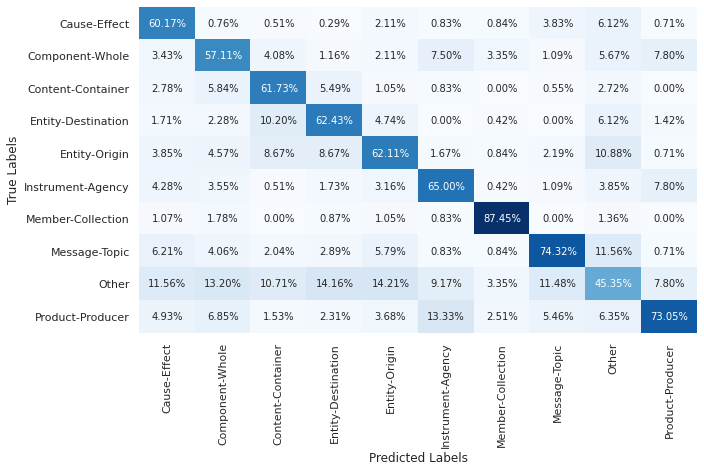

In [ ]:
# Confusion matrix for relations
y_test_temp = le_relation.inverse_transform(y_test)
y_pred_relation_temp = le_relation.inverse_transform(y_pred_relation)
data = confusion_matrix(y_test_temp, y_pred_relation_temp)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_temp), index = np.unique(y_test_temp))
df_cm.index.name = 'True Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (10,6))
sns.set(font_scale=1.0)
sns.heatmap(df_cm/np.sum(df_cm), cmap="Blues", fmt='.2%', annot=True, annot_kws={"size": 10}, cbar=False)

In [ ]:
# Classification report for relations
target_names = le_relation.classes_
print(classification_report(y_test, y_pred_relation, target_names=target_names))

                    precision    recall  f1-score   support

      Cause-Effect       0.60      0.86      0.71       328
   Component-Whole       0.57      0.72      0.64       312
 Content-Container       0.62      0.63      0.62       192
Entity-Destination       0.62      0.74      0.68       292
     Entity-Origin       0.62      0.46      0.53       258
 Instrument-Agency       0.65      0.50      0.57       156
 Member-Collection       0.87      0.90      0.89       233
     Message-Topic       0.74      0.52      0.61       261
             Other       0.45      0.44      0.45       454
  Product-Producer       0.73      0.45      0.55       231

          accuracy                           0.62      2717
         macro avg       0.65      0.62      0.62      2717
      weighted avg       0.63      0.62      0.61      2717



In [ ]:
# saving the model for predicting relations
Pkl_Filename = "Pickle_Relation_Model.pkl"  
pickle.dump(relation_classifier, open(Pkl_Filename, 'wb'))

In [ ]:
# loading the model for predicting relations
Pkl_Filename = "Pickle_Relation_Model.pkl"
relation_model = pickle.load(open(Pkl_Filename, 'rb'))

In [ ]:
relation_model.score(X_test, y_test)

0.6209054103790946

In [ ]:
# Dataframe with true and predicted labels
results = testDF[['Sentence', 'Relation_Direction', 'Relation', 'Direction']]
y_pred_test_relation = relation_model.predict(X_test)

y_pred_test_relation = le_relation.inverse_transform(y_pred_test_relation)

results['Predicted_Relation'] = pd.Series(y_pred_test_relation)

In [ ]:
results.head()

,Sentence,Relation_Direction,Relation,Direction,Predicted_Relation
0,The most common audits were about waste and re...,"Message-Topic(e1,e2)",Message-Topic,"(e1,e2)",Other
1,The company fabricates plastic chairs .,"Product-Producer(e2,e1)",Product-Producer,"(e2,e1)",Instrument-Agency
2,The school master teaches the lesson with a st...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",Instrument-Agency
3,The suspect dumped the dead body into a local ...,"Entity-Destination(e1,e2)",Entity-Destination,"(e1,e2)",Content-Container
4,Avian influenza is an infectious disease of bi...,"Cause-Effect(e2,e1)",Cause-Effect,"(e2,e1)",Cause-Effect


### Model for classifying direction

In [ ]:
trainDF_no_other = trainDF[trainDF['Relation'] != 'Other']
testDF_no_other = testDF[testDF['Relation'] != 'Other']

In [ ]:
featuresDF = pd.concat([trainDF[trainDF['Relation'] != 'Other'], testDF[testDF['Relation'] != 'Other']], ignore_index=True)
null_columns = featuresDF.columns[featuresDF.isna().any()].tolist()
featuresDF[null_columns] = featuresDF[null_columns].fillna('O')

In [ ]:
features_dict_direction = featuresDF[['Entity1', 'Entity2', 'Entity1_POS', 'Entity2_POS', 'before_E1', 'after_E2', 'wordCount_Bet_Noms',
                            'ShortestPath', 'ShortestPathLength', 'POS_bet_Noms', 'prefixes', 'E1_mero', 'E1_holo', 'E2_mero', 
                            'E2_holo', 'E1_hype', 'E2_hype', 'E1_hypo', 'E2_hypo']].to_dict('records')

In [ ]:
v_direction = DictVectorizer()
features_vec_direction = v_direction.fit_transform(features_dict_direction).toarray()
inputDF = pd.DataFrame(features_vec_direction)
inputDF['Direction'] = pd.Series(featuresDF['Direction'])

In [ ]:
le_direction = LabelEncoder()
inputDF['Direction'] = le_direction.fit_transform(inputDF['Direction'])

In [ ]:
le_direction.classes_

array(['(e1,e2)', '(e2,e1)'], dtype=object)

In [ ]:
X = inputDF.iloc[:,:-1]
y = inputDF.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2263, shuffle=False)

In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = GaussianNB()
clf3 = RandomForestClassifier()

direction_classifier = VotingClassifier(estimators=[('dt', clf1), ('gnb', clf2), ('rf', clf3)], voting='hard')

direction_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
   

In [ ]:
start = time.time()
y_pred_direction = direction_classifier.predict(X_test)
print('Accuracy of voting classifier for predicting direction is: {:1.2f}%'.format(accuracy_score(y_pred_direction, y_test)*100))
end = time.time()
print('Time taken to make predictions {:1.2f} seconds'.format(end - start))

Accuracy of voting classifier for predicting direction is: 92.36%
Time taken to make predictions 1.23 seconds


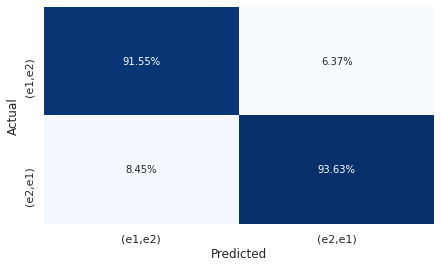

In [ ]:
y_test_temp = le_direction.inverse_transform(y_test)
y_pred_direction_temp = le_direction.inverse_transform(y_pred_direction)
data = confusion_matrix(y_test_temp, y_pred_direction_temp)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_temp), index = np.unique(y_test_temp))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,4))
sns.set(font_scale=1.0)
sns.heatmap(df_cm/np.sum(df_cm), cmap="Blues", fmt='.2%', annot=True,annot_kws={"size": 10}, cbar=False)

In [ ]:
# Classification report for relations
target_names_direction = le_direction.classes_
print(classification_report(y_test, y_pred_direction, target_names=target_names_direction))

              precision    recall  f1-score   support

     (e1,e2)       0.92      0.96      0.94      1323
     (e2,e1)       0.94      0.88      0.90       940

    accuracy                           0.92      2263
   macro avg       0.93      0.92      0.92      2263
weighted avg       0.92      0.92      0.92      2263



In [ ]:
# saving the model for predicting relations
Pkl_Filename = "Pickle_Direction_Model.pkl"  
pickle.dump(direction_classifier, open(Pkl_Filename, 'wb'))

In [ ]:
# loading the model for predicting relations
Pkl_Filename = "Pickle_Direction_Model.pkl"  
direction_model = pickle.load(open(Pkl_Filename, 'rb'))

In [ ]:
direction_model.score(X_test, y_test)

0.9235528060097216

### Combining both relation and direction

In [ ]:
results['Predicted_Direction'] = ''

y_pred_test_direction = direction_model.predict(X_test)
y_pred_test_direction = le_direction.inverse_transform(y_pred_test_direction)

direction_indices = testDF[testDF['Relation'] != 'Other'].index.values
for i in range(len(direction_indices)):
  results.loc[direction_indices[i], 'Predicted_Direction'] = y_pred_test_direction[i]

original_others = results[(results['Predicted_Direction'] == '') & (results['Predicted_Relation'] != 'Other')].index.values
for i in original_others:
  results.loc[i, 'Predicted_Direction'] = str(results.loc[i, 'Predicted_Direction']) + '(e1,e2)'

results['Predicted_Relation_Direction'] = results['Predicted_Relation'] + results['Predicted_Direction']
results['Predicted_Relation_Direction'] = results['Predicted_Relation_Direction'].replace('Other(e1,e2)', 'Other')
results['Predicted_Relation_Direction'] = results['Predicted_Relation_Direction'].replace('Other(e2,e1)', 'Other')

In [ ]:
results.head()

,Sentence,Relation_Direction,Relation,Direction,Predicted_Relation,Predicted_Direction,Predicted_Relation_Direction
0,The most common audits were about waste and re...,"Message-Topic(e1,e2)",Message-Topic,"(e1,e2)",Other,"(e1,e2)",Other
1,The company fabricates plastic chairs .,"Product-Producer(e2,e1)",Product-Producer,"(e2,e1)",Instrument-Agency,"(e2,e1)","Instrument-Agency(e2,e1)"
2,The school master teaches the lesson with a st...,"Instrument-Agency(e2,e1)",Instrument-Agency,"(e2,e1)",Instrument-Agency,"(e2,e1)","Instrument-Agency(e2,e1)"
3,The suspect dumped the dead body into a local ...,"Entity-Destination(e1,e2)",Entity-Destination,"(e1,e2)",Content-Container,"(e1,e2)","Content-Container(e1,e2)"
4,Avian influenza is an infectious disease of bi...,"Cause-Effect(e2,e1)",Cause-Effect,"(e2,e1)",Cause-Effect,"(e2,e1)","Cause-Effect(e2,e1)"


In [ ]:
# results.to_csv('results.csv')

## **Task 4**

In [ ]:
def get_metrics(y_true, y_pred):
  accuracy = round(accuracy_score(y_true, y_pred), 2)
  macro_precision = round(precision_score(y_true, y_pred, average='macro'), 2)
  macro_recall = round(recall_score(y_true, y_pred, average='macro'), 2)
  f1 = round(f1_score(y_true, y_pred, average='macro'), 2)
  return accuracy, macro_precision, macro_recall, f1

### Test set performance assuming relation is classified correctly (but not the direction)

In [ ]:
print('Assuming that the relation is classified correctly (but not the direction)')
metrics = get_metrics(results['Relation'], results['Predicted_Relation'])
print('Accuracy:', metrics[0])
print('macro precision:', metrics[1])
print('macro recall:', metrics[2])
print('macro f1-score:', metrics[3])

Assuming that the relation is classified correctly (but not the direction)
Accuracy: 0.62
macro precision: 0.65
macro recall: 0.62
macro f1-score: 0.62


### Test set performance assuming both the relation and direction are classified correctly

In [ ]:
print('Assuming both the relation and direction are classified correctly')
metrics = get_metrics(results['Relation_Direction'], results['Predicted_Relation_Direction'])
print('Accuracy:', metrics[0])
print('macro precision:', metrics[1])
print('macro recall:', metrics[2])
print('macro f1-score:', metrics[3])

Assuming both the relation and direction are classified correctly
Accuracy: 0.6
macro precision: 0.59
macro recall: 0.57
macro f1-score: 0.57


## **Demo**

In [ ]:
df = CorpusReader('demo.TXT')
df = features(df)
df = other_features(df)

In [ ]:
df.head()

,Sentence,Relation_Direction,Relation,Direction,Entity1,Entity2,Entity1_POS,Entity2_POS,Tokens,Lemmas,POS Tags,DEP Tags,DEP Parent POS,ShortestPath,ShortestPathLength,NE1,NE2,is_E1_hype,is_E1_hypo,is_E1_mero,is_E1_holo,is_E2_hype,is_E2_hypo,is_E2_mero,is_E2_holo,E1_hype,E1_hypo,E1_mero,E1_holo,E2_hype,E2_hypo,E2_mero,E2_holo,PathSimilarity,E1_Stems,E2_Stems,prefixes,before_E1,after_E2,POS_bet_Noms,wordCount_Bet_Noms,Gloss
0,"Skype, a free software, allows a hookup of mul...","Member-Collection(e2,e1)",Member-Collection,"(e2,e1)",hookup,users,NN,NNS,"[Skype, ,, a, free, software, ,, allows, a, ho...","[Skype, ,, a, free, software, ,, allow, a, hoo...","[NNP, ,, DT, JJ, NN, ,, VBZ, DT, NN, IN, JJ, N...","[nsubj, punct, det, amod, appos, punct, ROOT, ...","[VERB, PROPN, NOUN, NOUN, PROPN, PROPN, VERB, ...","[pobj, prep]",2,NONE,NONE,0,0,0,0,0,0,0,0,[connection],[O],[O],[O],[person],"[consumer, end_user, usufructuary, utilizer, w...",[O],[O],0.111111,hookup,user,"[of, multi, compu]",a,to,I_J_N,3,1


In [ ]:
features_dict_demo = df[['Entity1', 'Entity2', 'Entity1_POS', 'Entity2_POS', 'before_E1', 'after_E2', 'wordCount_Bet_Noms',
                            'ShortestPath', 'ShortestPathLength', 'POS_bet_Noms', 'prefixes', 'E1_mero', 'E1_holo', 'E2_mero', 
                            'E2_holo', 'E1_hype', 'E2_hype', 'E1_hypo', 'E2_hypo']].to_dict('records')

### Predicting relation

In [ ]:
# loading the model for predicting relations
Pkl_Filename = "Pickle_Relation_Model.pkl" 
relation_model = pickle.load(open(Pkl_Filename, 'rb'))

In [ ]:
demo_relation_vec = v_relation.transform(features_dict_demo)

In [ ]:
predicted_relation = le_relation.inverse_transform(relation_model.predict(demo_relation_vec.toarray()))

### Predicting direction

In [ ]:
# loading the model for predicting relations
Pkl_Filename = "Pickle_Direction_Model.pkl"  
direction_model = pickle.load(open(Pkl_Filename, 'rb'))

In [ ]:
demo_direction_vec = v_direction.transform(features_dict_demo)

In [ ]:
predicted_direction = le_direction.inverse_transform(direction_model.predict(demo_direction_vec.toarray()))

In [ ]:
print('True Relation and Direction:', df.iloc[0, 1])
print('Predicted Relation Direction:', predicted_relation[0] + predicted_direction[0])

True Relation and Direction: Member-Collection(e2,e1)
Predicted Relation Direction: Member-Collection(e2,e1)


## Other unsuccessful features

In [ ]:
# Assumption: entities are single token
def vectorial(sentence, entity1, entity2):
  entity1 = get_tokens(entity1)
  entity2 = get_tokens(entity2)
    
  tokens = get_tokens(sentence)
  e1_start_index, e1_end_index = find_sub_list(tokens, entity1)
  e2_start_index, e2_end_index = find_sub_list(tokens, entity2)

  e1_start = e1_start_index-3
  e1_end = e1_end_index+3
  e2_start = e2_start_index-3
  e2_end = e2_end_index+3

  count1 = -(abs(e1_end_index) - abs(e1_start_index))
  count2 = -(abs(e2_end_index) - abs(e2_start_index))

  entities_before_e1 = []
  entities_after_e1 = []
  entities_before_e2 = []
  entities_after_e2 = []
  while(count1 <= 6):
    if e1_start >= 0 and e1_start < len(tokens):
      if e1_start < e1_start_index:
        entities_before_e1.append(tokens[e1_start])
      elif e1_start > e1_end_index:
        entities_after_e1.append(tokens[e1_start])
    e1_start += 1
    count1 += 1
  while(count2 <= 6):
    if e2_start >= 0 and e2_start < len(tokens):
      if e2_start < e2_start_index:
        entities_before_e2.append(tokens[e2_start])
      elif e2_start > e2_end_index:
        entities_after_e2.append(tokens[e2_start])
    e2_start += 1
    count2 += 1
  return [entities_before_e1, entities_after_e1, entities_before_e2, entities_after_e2]

trainDF['3term_words'] = trainDF.apply(lambda x: vectorial(x.Sentence, x.Entity1, x.Entity2), axis=1)
vectorial(trainDF.iloc[8,0], trainDF.iloc[8,4], trainDF.iloc[8,5])

[['The'],
 ['was', 'contained', 'in'],
 ['contained', 'in', 'a'],
 ['and', 'the', 'counter']]

In [ ]:
# google 5-gram
import urllib 
import requests 
 
encoded_query = urllib.parse.quote('??motion??')
params = {'corpus': 'eng-us', 'query': encoded_query, 'topk': 10, 'format': 'tsv'} 
params = '&'.join('{}={}'.format(name, value) for name, value in params.items()) 
print(params)
 
response = requests.get('https://api.phrasefinder.io/search?' + params) 

print(response.text)

corpus=eng-us&query=%3F%3Fmotion%3F%3F&topk=10&format=tsv
of_1 the_1 motion_0 of_1 the_1	62161	36804	1654	2009	1120986486144	0.181465
,_1 the_1 motion_0 of_1 the_1	42809	31316	1713	2009	1120986503612	0.124971
by_1 the_1 motion_0 of_1 the_1	41664	32116	1507	2009	1120986505291	0.121629
set_1 in_1 motion_0 by_1 the_1	40870	36500	1747	2009	1120986506554	0.119311
Academy_1 of_1 Motion_0 Picture_1 Arts_1	28343	10765	1893	2009	1120986538183	0.082741
that_1 the_1 motion_0 of_1 the_1	27487	20435	1665	2009	1120986541726	0.0802421
with_1 the_1 motion_0 of_1 the_1	26527	23269	1713	2009	1120986545914	0.0774396
and_1 the_1 motion_0 of_1 the_1	25063	21588	1657	2009	1120986553226	0.0731657
direction_1 of_1 motion_0 of_1 the_1	24203	13702	1831	2009	1120986558074	0.0706552
on_1 the_1 motion_0 of_1 the_1	23424	17006	1760	2009	1120986562770	0.0683811

